In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import requests

In [5]:
startTime = 1502928000000      
endTime   = 4102444800000      
limit     = 1000

chunks = []
while startTime < endTime:
    url = ("https://api.binance.com/api/v3/klines"
           f"?symbol=BTCUSDT&interval=1d&limit={limit}&startTime={startTime}")
    data = requests.get(url, timeout=30).json()
    if not data:
        break

    df = pd.DataFrame(data, columns=[
        "Open time","Open","High","Low","Close","Volume",
        "Close time","Quote asset volume","Number of trades",
        "Taker buy base asset volume","Taker buy quote asset volume","Ignore"
    ])

    df["Date"] = pd.to_datetime(df["Open time"], unit="ms")

    df = df[["Date","Open","High","Low","Close","Volume"]]

    num_cols = ["Open","High","Low","Close","Volume"]
    df[num_cols] = df[num_cols].astype(float)

    chunks.append(df)

    # esto es lo que mejora lo que habia hecho el mija
    startTime = data[-1][6] + 1


btc = (pd.concat(chunks, ignore_index=True)
         .drop_duplicates(subset="Date")
         .sort_values("Date")
         .set_index("Date"))

btc.to_csv("btc_usdt_binance_daily.csv")
btc.tail()

Open       High        Low      Close       Volume
Date                                                               
2025-09-10  111546.38  114313.13  110917.45  113960.00  17517.41823
2025-09-11  113960.00  115488.09  113430.00  115482.69  13676.73119
2025-09-12  115482.69  116665.63  114740.99  116029.42  15324.10719
2025-09-13  116029.41  116298.78  115127.27  115918.29   8269.40394
2025-09-14  115918.29  116165.19  115141.80  115900.00   5770.71867

In [6]:
btc.sample(n=100, random_state=42)


Open       High        Low      Close         Volume
Date                                                                 
2019-10-16    8159.30    8181.16    7917.00    7991.74   34733.593966
2018-04-20    8273.84    8930.00    8177.09    8856.98   39795.337485
2025-01-28  102082.83  103800.00  100272.68  101335.52   22022.057650
2024-06-08   69355.60   69582.20   69168.02   69310.46    9773.829670
2025-05-24  107318.30  109506.03  106875.41  107761.91   16782.531290
...               ...        ...        ...        ...            ...
2024-03-17   65300.64   68904.40   64533.00   68393.48   49742.215890
2024-05-18   67024.00   67400.01   66600.00   66915.20   14441.257740
2022-12-10   17128.56   17227.72   17092.00   17127.49  140573.979370
2017-11-27    9128.00    9654.28    9112.04    9650.00    4521.625707
2019-09-28    8177.47    8315.00    8001.09    8198.81   34473.605165

[100 rows x 5 columns]

Open       High        Low      Close       Volume
Date                                                               
2025-09-10  111546.38  114313.13  110917.45  113960.00  17517.41823
2025-09-11  113960.00  115488.09  113430.00  115482.69  13676.73119
2025-09-12  115482.69  116665.63  114740.99  116029.42  15324.10719
2025-09-13  116029.41  116298.78  115127.27  115918.29   8269.40394
2025-09-14  115918.29  116165.19  115141.80  115900.00   5770.71867

Open           High            Low          Close  \
count    2951.000000    2951.000000    2951.000000    2951.000000   
mean    33479.393436   34217.577350   32694.770840   33517.273484   
std     29921.723519   30432.424544   29401.415691   29955.325700   
min      3188.010000    3276.500000    2817.000000    3189.020000   
25%      8914.180000    9197.610000    8700.000000    8915.330000   
50%     23629.760000   24226.000000   23106.770000   23643.510000   
75%     49142.955000   50517.845000   47500.000000   49188.705000   
max    123306.440000  124474.000000  118920.920000  123306.430000   

              Volume  
count    2951.000000  
mean    64044.167776  
std     77790.834801  
min       228.108068  
25%     25534.284240  
50%     40872.229909  
75%     67867.650774  
max    760705.362783

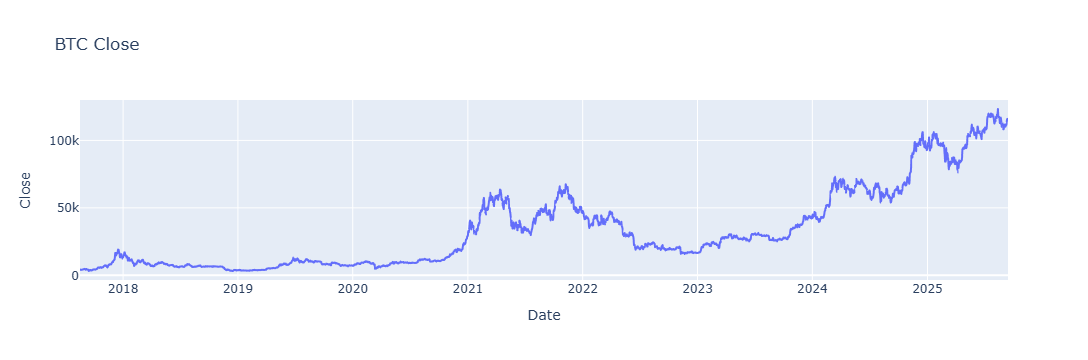

In [16]:
btc = pd.read_csv("btc_usdt_binance_daily.csv", parse_dates=["Date"], index_col="Date")
btc = btc[~btc.index.duplicated(keep="first")].asfreq("D").ffill()

display(btc.tail(), btc.describe())

fig = px.line(btc, x=btc.index, y="Close", title="BTC Close")
fig.show()


In [8]:
btc.shape



(2951, 5)

In [9]:
n_raw = btc.shape[0]

n_clean = btc.shape[0]

print(f"Registros originales: {n_raw}")
print(f"Registros después de limpieza: {n_clean}")
print(f"Diferencia: {n_raw - n_clean}")

if n_raw-n_clean == 0:
    print("Todos los registros del dataframe son distintos")


Registros originales: 2951
Registros después de limpieza: 2951
Diferencia: 0
Todos los registros del dataframe son distintos


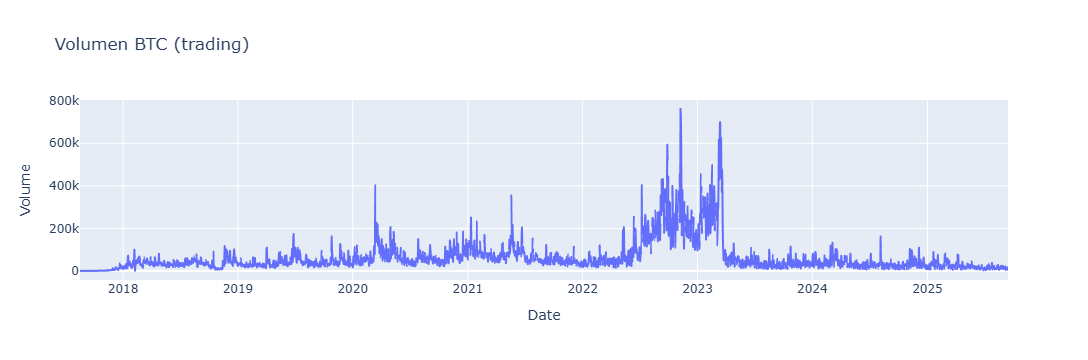

In [17]:
# Volumen
fig = px.line(btc, x=btc.index, y="Volume", title="Volumen BTC (trading)")
fig.show()


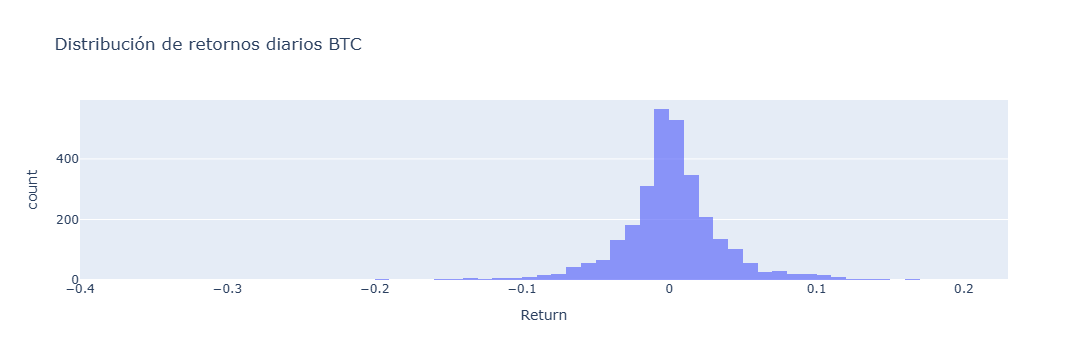

In [22]:
btc["Return"] = btc["Close"].pct_change()
fig = px.histogram(
    btc.dropna(),      
    x="Return", 
    nbins=100, 
    opacity=0.7, 
    title="Distribución de retornos diarios BTC"
)
fig.show()


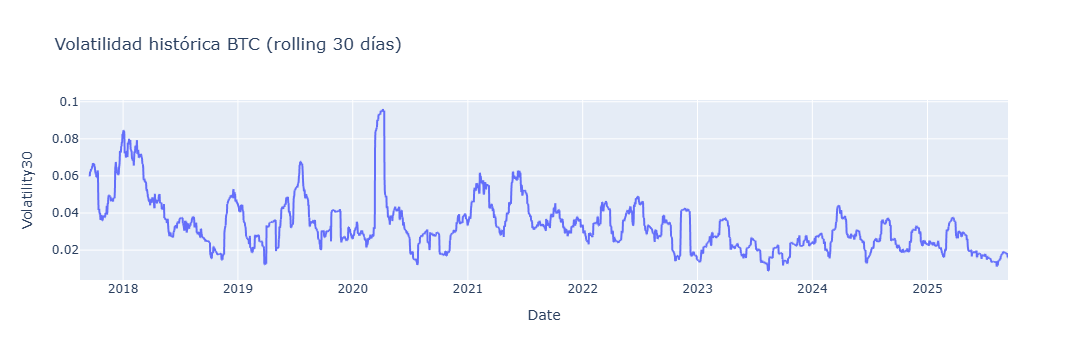

In [23]:

btc["Volatility30"] = btc["Return"].rolling(window=30).std()

fig = px.line(
    btc, 
    x=btc.index, 
    y="Volatility30", 
    title="Volatilidad histórica BTC (rolling 30 días)"
)
fig.show()


In [27]:
btc["MA7"]  = btc["Close"].rolling(window=7).mean()   
btc["MA30"] = btc["Close"].rolling(window=30).mean()  

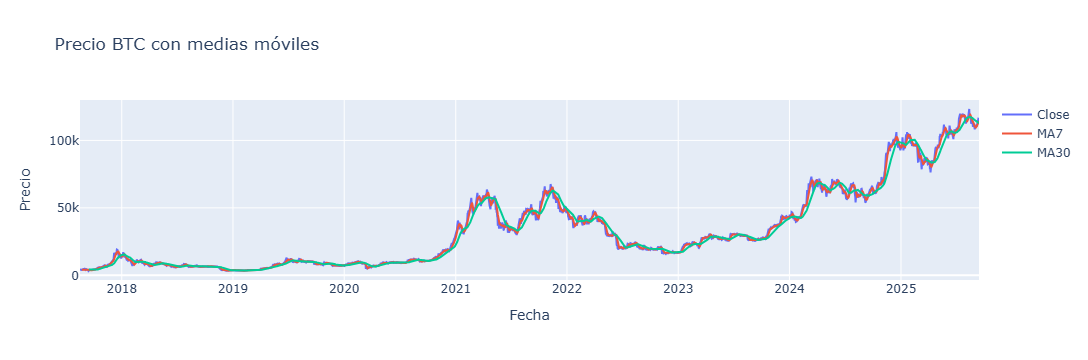

In [29]:
import plotly.graph_objects as go

fig = go.Figure()
for col in ["Close", "MA7", "MA30"]:
    fig.add_trace(go.Scatter(x=btc.index, y=btc[col], mode="lines", name=col))
fig.update_layout(title="Precio BTC con medias móviles", xaxis_title="Fecha", yaxis_title="Precio")
fig.show()


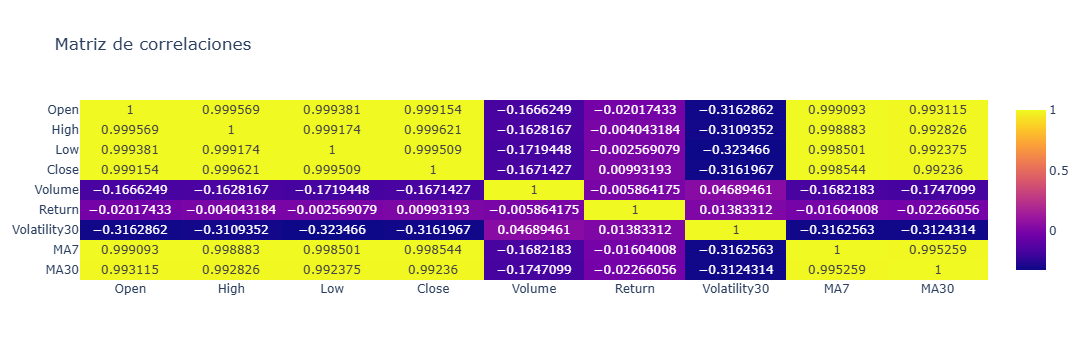

In [30]:
fig = px.imshow(
    btc.corr(),
    text_auto=True,
    aspect="auto",
    title="Matriz de correlaciones"
)
fig.show()